# Visualization of Latent Vector by tSNE

このノートブックでは、事前学習によって画像をベクトル空間に埋め込んだ結果をtSNEという可視化手法によって視覚的に評価します。

実装はsklearnのもの[1]を使います。

https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

# import modules

In [1]:
! pip -q install timm

     |████████████████████████████████| 378kB 4.3MB/s 


In [2]:
! pip -q install --force-reinstall --pre --extra-index https://pypi.anaconda.org/scipy-wheels-nightly/simple scikit-learn

     |████████████████████████████████| 22.9MB 1.0MB/s 
     |████████████████████████████████| 28.7MB 192kB/s 
     |████████████████████████████████| 15.8MB 14.5MB/s 
     |████████████████████████████████| 307kB 5.8MB/s 
ERROR: tensorflow 2.5.0 has requirement numpy~=1.19.2, but you'll have numpy 1.22.0.dev0+503.g94de9f700 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [3]:
import sklearn
sklearn.__version__

'1.0.dev0'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random

from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedGroupKFold

import timm
import torch
from torch import nn
from torch.utils import data
from tqdm.auto import tqdm

# torchvision
from torchvision import transforms as T

# mount google drive

このnotebook では Google Drive からモデルをダウンロードしていますが、ローカルに展開できていればどこから持ってきても大丈夫です。

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# download dataset

In [6]:
import os

In [ ]:
import os

def setup_data():
    if not os.path.isfile('dataset_atmaCup11.zip'):
        ! cp {PROJECT_DIR}/dataset_atmaCup11.zip .
    if not os.path.isfile('photos.zip'):
        ! unzip -q dataset_atmaCup11.zip
    if not os.path.isdir('photos'):
        ! unzip -q photos.zip -d photos

PROJECT_DIR = '/content/drive/MyDrive/Colab\ Notebooks/AtmaCup11'
setup_data()

# define data loader and utility functions

In [7]:
IMAGE_SIZE = 224

In [8]:
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]

class AtmaDataset(data.Dataset):
    """atmaCup用にデータ読み込み等を行なうデータ・セット"""
    object_path_key = "object_path"
    label_key = "soft_target"

    @property
    def meta_keys(self):
        retval = [self.object_path_key]

        if self.is_train:
            retval += [self.label_key]

        return retval

    def __init__(self, meta_df: pd.DataFrame, is_train=True):
        """
        args:
            meta_df: 
                画像へのパスと label 情報が含まれている dataframe
                必ず object_path に画像へのパス, target に正解ラベルが入っている必要があります

            is_train:
                True のとき学習用のデータ拡張を適用します.
                False の時は単に size にリサイズを行います
        """

        self.is_train = is_train
        for k in self.meta_keys:
            if k not in meta_df:
                raise ValueError("meta df must have {}".format(k))

        self.meta_df = meta_df.reset_index(drop=True)
        self.index_to_data = self.meta_df.to_dict(orient="index")

        size = (IMAGE_SIZE, IMAGE_SIZE)

        additional_items = (
            [T.Resize(size)]
            if not is_train
            else [
                #T.RandomGrayscale(p=0.2),
                #T.RandomVerticalFlip(),
                T.RandomHorizontalFlip(),
                #T.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2, hue=0.05),
                T.RandomResizedCrop(size),
                #T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
            ]
        )

        self.transformer = T.Compose(
            [*additional_items, T.ToTensor(), T.Normalize(mean=IMG_MEAN, std=IMG_STD)]
        )

    def __getitem__(self, index):
        data = self.index_to_data[index]

        obj_path, label = data.get(self.object_path_key), data.get(self.label_key, -1)
        img = Image.open(obj_path)
        img = self.transformer(img)
        return img, label

    def __len__(self):
        return len(self.meta_df)
# CUDA を使うので確認. google colab の場合 GPU accelerator をオンにしておいてください
assert torch.cuda.is_available()

DEVICE = torch.device("cuda")

In [9]:
def create_metadata(input_df):
    targets = ['target', 'soft_target']
    out_df = input_df[['object_id']].copy()
    out_df['object_path'] = input_df['object_id'].map(to_img_path)

    for target in targets:
        if target in input_df:
            out_df[target] = input_df[target]
    
    return out_df

In [10]:
from PIL import Image

def to_img_path(object_id):
    return os.path.join(photo_dir, f'{object_id}.jpg')

def read_image(object_id):
    return Image.open(to_img_path(object_id))

In [11]:
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

In [12]:
dataset_root = '/content/drive/MyDrive/atmacup11/'
assert dataset_root is not None

input_dir = os.path.join(dataset_root, "datasets")
photo_dir = os.path.join(input_dir, "photos")

output_dir = os.path.join(dataset_root, "outputs_nb016")
os.makedirs(output_dir, exist_ok=True)

# SSL 事前学習にて獲得した重みを使用する
pretrained_dir = os.path.join(dataset_root, 'outpus_nb015')

train_df = pd.read_csv(os.path.join(input_dir, 'train.csv'))
test_df = pd.read_csv(os.path.join(input_dir, 'test.csv'))

material_df = pd.read_csv(os.path.join(input_dir, 'materials.csv'))
technique_df = pd.read_csv(os.path.join(input_dir, 'techniques.csv'))

RANDOM_SEED = 330

In [13]:

train_meta_df = create_metadata(train_df)

set_seed(2929)

fold = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=2929)
cv = fold.split(X=train_df, y=train_df['target'], groups=train_df['art_series_id'])

_, val_idx = next(cv)
valid_df = train_meta_df.loc[val_idx]
valid_dataset = AtmaDataset(meta_df=valid_df, is_train=False)
valid_loader = data.DataLoader(valid_dataset, batch_size=256)

# Download trained model

学習したモデルをローカルにダウンロードします。

In [ ]:
# after pre-training
#! cp /content/drive/MyDrive/Colab\ Notebooks/AtmaCup11/sup_contrast/model/backbone_resnet34d_best_in_epoch100_fold0.pt .

In [14]:
model_path = '/content/drive/MyDrive/atmacup11/outputs_nb015/pre_trained.pth'
model = torch.load(model_path)

In [ ]:
# after fine tune
# ! cp /content/drive/MyDrive/Colab\ Notebooks/AtmaCup11/2nd_stage_resnet34d_epoch150_224x224/best_model_0.pt .

In [ ]:
# # after fine tune
# parent_model = torch.load('best_model_0.pt')
# model = parent_model.backbone

In [15]:
class AtmaModel(nn.Module):
    def __init__(self, model_path, n_feature=512, hidden_dim=512, w_dim=512):
        super(AtmaModel, self).__init__()
        assert os.path.isfile(model_path), f'The model path {model_path} not exists!'
        self.backbone = torch.load(model_path, map_location=DEVICE)
        #self.mapping = MappingLayers(z_dim=n_feature, hidden_dim=hidden_dim, w_dim=w_dim)
        #self.activation = nn.LeakyReLU(0.2)
        self.fc = nn.Linear(n_feature, 1, bias=True)

    def forward(self, x):
        x = self.backbone(x)
        #x = self.mapping(x)
        #x = self.activation(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [16]:
t = tqdm(valid_loader)
model.eval()

for i, batch in enumerate(t):
    image, label = batch

    image = image.to(DEVICE)
    label = label.to(DEVICE)

    with torch.no_grad():
        z = model(image)
    
    z_array = z.to('cpu').numpy()

    if i == 0:
        zs = z_array
    else:
        zs = np.concatenate((zs, z_array), axis=0)


AttributeError: ignored

In [ ]:
zs.shape

(784, 512)

In [ ]:
ys = valid_df['target'].values
ys.shape

(784,)

In [ ]:
tsne = TSNE(n_components=2, random_state=2929, perplexity=30, n_iter=1000)

tsne_results = tsne.fit_transform(zs)

print(tsne_results.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:767: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:777: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(784, 2)


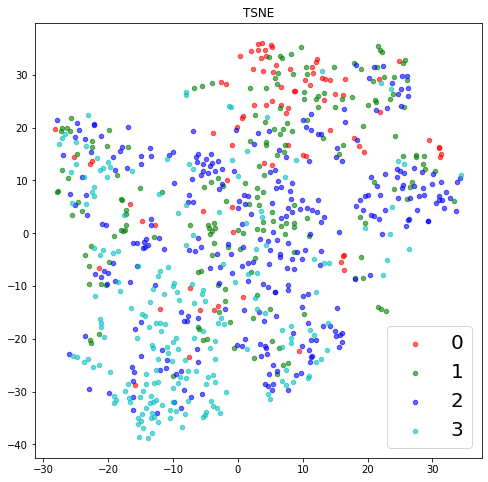

In [ ]:
# Create the figure
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1, title='TSNE')

classes = np.unique(ys)
colors = ['r', 'g', 'b', 'c']

for c in classes:
    ys_c = ys[ys == c]
    tsne_results_c = tsne_results[ys == c]
    # Create the scatter
    ax.scatter(
        x=tsne_results_c[:, 0],
        y=tsne_results_c[:, 1],
        c=colors[c],
        label=c,
        alpha=0.6,
        s=20)

plt.legend(fontsize=20)
plt.show()

以上が埋め込んだ先のベクトル空間を2次元に可視化した様子です。
事前学習の結果を定性的に評価するのに便利です。